In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import close, figure, imshow, savefig, show, title
from matplotlib.lines import Line2D
import os
import seaborn as sns
# from os.path import join
from random import sample
from re import split
import numpy as np
import pandas as pd

In [3]:
import torch
from torchvision import datasets
from torchvision import transforms

from torch.nn import Linear, Module, MSELoss, ReLU, Sequential, Sigmoid, LeakyReLU


from torch import device, no_grad
from torch.cuda import is_available
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torchvision.utils import make_grid

from torchsummary import summary

In [4]:
# importing the required libraries

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

### Autoencoder training class and functions

In [5]:
class AutoEncoder(Module):
    '''A class that implements an AutoEncoder
    '''
    @staticmethod
    def get_non_linearity(params):
        '''Determine which non linearity is to be used for both encoder and decoder'''
        def get_one(param):
            '''Determine which non linearity is to be used for either encoder or decoder'''
            param = param.lower()
            if param=='relu': return ReLU()
            if param=='sigmoid': return Sigmoid()
            if param=='leakyrelu': return LeakyReLU()
            return None

        # decoder_non_linearity = get_one(params[0])
        # encoder_non_linearity = getnl(params[a]) if len(params)>1 else decoder_non_linearity

        encoder_non_linearity = get_one(params[0])
        decoder_non_linearity = getnl(params[a]) if len(params)>1 else encoder_non_linearity

        return encoder_non_linearity,decoder_non_linearity

    @staticmethod
    def build_layer(sizes,
                    non_linearity = None,
                    last_layer_nonlinear = True):
        '''Construct encoder or decoder as a Sequential of Linear labels, with or without non-linearities

        Positional arguments:
            sizes   List of sizes for each Linear Layer
        Keyword arguments:
            non_linearity  Object used to introduce non-linearity between layers
        '''
        linears = [Linear(m,n) for m,n in zip(sizes[:-1],sizes[1:])]
        if non_linearity==None:
            return Sequential(*linears)
        else:
            ae_layers = [item for pair in [(layer,non_linearity) for layer in linears] for item in pair]
            if last_layer_nonlinear:
                return Sequential(*ae_layers)
                # return Sequential(*[item for pair in [(layer,non_linearity) for layer in linears] for item in pair])
            else:
                return Sequential(*ae_layers[:-1])


    def __init__(self,
                 encoder_sizes         = [33*33,400,200,100,50,25,6],
                 encoder_non_linearity = ReLU(inplace=True),
                 decoder_sizes         = [],
                 decoder_non_linearity = ReLU(inplace=True)):
        '''
        Keyword arguments:
            encoder_sizes            List of sizes for each Linear Layer in encoder
            encoder_non_linearity    Object used to introduce non-linearity between encoder layers
            decoder_sizes            List of sizes for each Linear Layer in decoder
            decoder_non_linearity    Object used to introduce non-linearity between decoder layers
        '''
        super().__init__()
        self.encoder_sizes = encoder_sizes
        self.decoder_sizes = encoder_sizes[::-1] if len(decoder_sizes)==0 else decoder_sizes
        self.encoder = AutoEncoder.build_layer(self.encoder_sizes,
                                               non_linearity = encoder_non_linearity)
        self.decoder = AutoEncoder.build_layer(self.decoder_sizes,
                                               non_linearity = decoder_non_linearity)

        ########### Build your own special layers ##########
        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Linear(28 * 28, 128),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(128, 64),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(64, 36),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(36, 18),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(18, 9)
        # )
        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Linear(9, 18),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(18, 36),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(36, 64),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(64, 128),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(128, 28 * 28),
        #     torch.nn.Sigmoid()
        # )
        ########### Build your own special layers ##########

        self.encode  = True
        self.decode  = True


    def forward(self, x):
        '''Propagate value through network

           Computation is controlled by self.encode and self.decode
        '''
        if self.encode:
            x = self.encoder(x)

        if self.decode:
            x = self.decoder(x)
        return x

    def n_encoded(self):
        return self.encoder_sizes[-1]

In [6]:
def train(loader,model,optimizer,criterion,dimension,
          N   = 25,
          dev = 'cpu'):
    '''Train network

       Parameters:
           loader       Used to get data
           model        Model to be trained
           optimizer    Used to minimze errors
           criterion    Used to compute errors
           dimension    (-1,33*33*40) example to show how to reshape tensor
      Keyword parameters:
          N             Number of epochs
          dev           Device - cpu or cuda
    '''
    Losses = []
    outputs_list = []

    for epoch in range(N):
        loss = 0
        for (batch_features, _) in loader:
            batch_features = batch_features.view(dimension).to(dev)
            # optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = torch.sqrt(criterion(outputs, batch_features))
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        Losses.append(loss/len(loader))
        print(f'epoch : {epoch+1}/{N}, average RMSE loss = {Losses[-1]:.6f}')
        outputs_list.append((epoch, batch_features, outputs))
    return Losses

In [51]:
def latent_vector_encoder(model, data, encoder):
    model.encode  = True
    model.decode  = False

    latent_vector = model(data.view(-1, encoder[0]))
    return latent_vector


def latent_vector_decoder(model, latent_vec, dimension):
    model.encode  = False
    model.decode  = True

    outputs = model(latent_vec)
    reconstructed_data = outputs.view(dimension)

    return reconstructed_data

def ae_prediction(model, data, encoder, dimension):
    model.encode  = True
    model.decode  = True

    outputs = model(data.view(-1, encoder[0])).view(dimension)
    return outputs

def save_latent_vector(latent_vec, path2file):
    save_data = latent_vec.detach().numpy()
    df = pd.DataFrame(data=save_data, columns=[f'dim{int(ii+1)}' for ii in range(save_data.shape[-1])])
    df.to_csv(path2file, index=False)
    return print(f"Latent vector saved in csv with shape of {save_data.shape}")


def plot_image_comparison(image, ae_pred, sample_idx=False, time_idx=False, cmap=plt.cm.gray, cbar_label="Land surface uplift, ft"):
    # from mpl_toolkits.axes_grid1 import make_axes_locatable

    ##### Check the index: sample_idx and time_idx start from 1 #####
    if sample_idx is not False and sample_idx < 1:
        print('The sample_idx should start from 1 .....')
    if time_idx is not False and time_idx < 1:
        print('The time_idx should start from 1 .....')


    if sample_idx and time_idx:
        raw_image = image[int(sample_idx-1), :, :, int(time_idx-1)]
        pred_image = ae_pred[int(sample_idx-1), :, :, int(time_idx-1)]
        title = f"The {int(sample_idx)} sample after {int(time_idx)} years of injection"
    elif sample_idx:
        raw_image = image[int(sample_idx-1), :, :]
        pred_image = ae_pred[int(sample_idx-1), :, :]
        title = f"The {int(sample_idx)} sample"
    elif time_idx:
        raw_image = image[:, :, int(time_idx-1)]
        pred_image = ae_pred[:, :, int(time_idx-1)]
        title = f"Query at time after {int(time_idx)} years of injection"
    else:
        raw_image = image
        pred_image = ae_pred
        title = ""

    abs_diff = np.abs(raw_image - pred_image)
    max_val = max(np.max(raw_image), np.max(pred_image))
    max_val_diff = np.max(abs_diff)

    plt.figure(figsize = (18,5))

    plt.subplot(1, 3, 1)
    ax1 = plt.gca()
    if cmap:
        plt.imshow(raw_image,cmap = cmap,vmin=0,vmax=max_val)
    else:
        plt.imshow(raw_image,vmin=0,vmax=max_val)
    plt.xlabel('X coordinate', fontsize=14)
    plt.ylabel('Y coordinate', fontsize=14)
    plt.title('Raw image', fontsize=14)
    ax1.axes.get_xaxis().set_ticks([])
    ax1.axes.get_yaxis().set_ticks([])
    ### Set color bar ###
    cbar = plt.colorbar(shrink=0.7)
    cbar.set_label(cbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=12)


    plt.subplot(1, 3, 2)
    ax2 = plt.gca()
    if cmap:
        plt.imshow(pred_image,cmap = cmap,vmin=0,vmax=max_val)
    else:
        plt.imshow(pred_image,vmin=0,vmax=max_val)
    plt.xlabel('X coordinate', fontsize=14)
    plt.ylabel('Y coordinate', fontsize=14)
    plt.title('Reconstructed image', fontsize=14)
    ax2.axes.get_xaxis().set_ticks([])
    ax2.axes.get_yaxis().set_ticks([])
    cbar = plt.colorbar(shrink=0.7)
    cbar.set_label(cbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=12)


    plt.subplot(1, 3, 3)
    ax3 = plt.gca()
    if cmap:
        plt.imshow(abs_diff,cmap = cmap,vmin=0,vmax=max_val)
    else:
        plt.imshow(abs_diff,vmin=0,vmax=max_val_diff)
    plt.xlabel('X coordinate', fontsize=14)
    plt.ylabel('Y coordinate', fontsize=14)
    plt.title('Absoluate difference', fontsize=14)
    ax3.axes.get_xaxis().set_ticks([])
    ax3.axes.get_yaxis().set_ticks([])
    cbar = plt.colorbar(shrink=0.7)
    cbar.set_label(cbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.suptitle(title, fontsize=18)
    plt.show()



## Feed data and initialize network

In [8]:
folder_path = 'drive/MyDrive/Colab Notebooks/Research'
dfexp = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
dfexpX = dfexp[dfexp.columns[4:-1]]
disp_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))

In [9]:
# image = torch.tensor(np.random.rand(100,33,33,5), dtype=torch.float32)
# label = torch.tensor(np.random.rand(100), dtype=torch.float32)

image = torch.tensor(disp_npy, dtype=torch.float32)
label = torch.tensor(np.random.rand(disp_npy.shape[0]), dtype=torch.float32)

# dataset = TensorDataset(testX, batch_size  = 128)
dataset = TensorDataset(image, label)
dataloader = DataLoader(dataset, shuffle=True, batch_size=7)

train_loader = dataloader
test_loader = dataloader

In [10]:
image.shape

torch.Size([196, 33, 33, 30])

In [11]:
ENCODER = [33*33*30,2**13,2**12,2**10,2**8,2**6,2**4,2**3]  # sizes of encoder layers
DECODER = []                           # Decoder layers will be a mirror image of encoder
LR      = 0.000001                        # Learning rate
N       = 128                           # Number of epochs
decode_dimension = (-1,33,33,30)

In [12]:
dev = device("cuda" if is_available() else "cpu")
encoder_non_linearity,decoder_non_linearity = AutoEncoder.get_non_linearity(['leakyrelu'])
model         = AutoEncoder(encoder_sizes         = ENCODER,
                            encoder_non_linearity = encoder_non_linearity,
                            decoder_non_linearity = decoder_non_linearity,
                            decoder_sizes         = DECODER).to(dev)
optimizer     = Adam(model.parameters(),
                     lr = LR,
                     weight_decay = 1e-8)
criterion     = MSELoss()


# transform     = Compose([ToTensor()])
# train_dataset = MNIST(root="~/torch_datasets",
#                       train     = True,
#                       transform = transform,
#                       download  = True)
# test_dataset  = MNIST(root="~/torch_datasets",
#                       train     = False,
#                       transform = transform,
#                       download  = True)
# train_loader  = DataLoader(train_dataset,
#                            batch_size  = 128,
#                            shuffle     = True,
#                            num_workers = 4)
# test_loader   = DataLoader(test_dataset,
#                            batch_size  = 32,
#                            shuffle     = False,
#                            num_workers = 4)

In [13]:
# summary(model, input_size=(1,ENCODER[0],ENCODER[0]))

## Training process

In [13]:
Losses = train(train_loader,model,optimizer,criterion,
              dimension = (-1, ENCODER[0]),
              N   = N,
              dev = dev)

epoch : 1/128, average RMSE loss = 0.014214
epoch : 2/128, average RMSE loss = 0.013830
epoch : 3/128, average RMSE loss = 0.013364
epoch : 4/128, average RMSE loss = 0.012889
epoch : 5/128, average RMSE loss = 0.012708
epoch : 6/128, average RMSE loss = 0.012201
epoch : 7/128, average RMSE loss = 0.011688
epoch : 8/128, average RMSE loss = 0.011212
epoch : 9/128, average RMSE loss = 0.010831
epoch : 10/128, average RMSE loss = 0.010384
epoch : 11/128, average RMSE loss = 0.010078
epoch : 12/128, average RMSE loss = 0.009680
epoch : 13/128, average RMSE loss = 0.009419
epoch : 14/128, average RMSE loss = 0.009206
epoch : 15/128, average RMSE loss = 0.009023
epoch : 16/128, average RMSE loss = 0.009023
epoch : 17/128, average RMSE loss = 0.009063
epoch : 18/128, average RMSE loss = 0.008859
epoch : 19/128, average RMSE loss = 0.008793
epoch : 20/128, average RMSE loss = 0.008783
epoch : 21/128, average RMSE loss = 0.008763
epoch : 22/128, average RMSE loss = 0.008762
epoch : 23/128, ave

## Save or load the model

In [34]:
# torch.save(model,'aemodel_test1.pt')

# load_model = torch.load('aemodel.pth')
# load_model.eval()


In [39]:
torch.save(model.state_dict(), os.path.join(folder_path, 'AE_models', 'aemodel_statedict_leakyReLU_128epoch.pt'))

In [40]:
# dev = device("cuda" if is_available() else "cpu")
encoder_non_linearity,decoder_non_linearity = AutoEncoder.get_non_linearity(['leakyrelu'])
load_model = AutoEncoder(
                        # encoder_sizes = [33*33*30,2**12,2**10,2**8,2**6,2**4,2**3],
                        encoder_sizes = [33*33*30,2**13,2**12,2**10,2**8,2**6,2**4,2**3],
                        encoder_non_linearity = encoder_non_linearity,
                        decoder_non_linearity = decoder_non_linearity,
                        decoder_sizes         = DECODER).to(device("cuda" if is_available() else "cpu"))
load_model.load_state_dict(torch.load(os.path.join(folder_path, 'AE_models', 'aemodel_statedict_leakyReLU_128epoch.pt')))
load_model.eval()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1022.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 705.06 MiB is free. Process 403525 has 14.06 GiB memory in use. Of the allocated memory 13.87 GiB is allocated by PyTorch, and 56.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:

summary(load_model, input_size=(1,ENCODER[0],ENCODER[0]))


In [54]:
latent_vector = latent_vector_encoder(load_model.cpu(), image.cpu(), ENCODER)
save_latent_vector(latent_vector, path2file=os.path.join(folder_path, 'AE_models', 'aemodel_leakyReLU_128epoch_latent_vector.csv'))

Latent vector saved in csv with shape of (196, 8)


In [ ]:
model = load_model

## Reconstruction

In [14]:
def reconstruct(loader,model,criterion,dimension,encoder,
                N        = 32,
                prefix   = 'test',
                show     = False,
                figs     = './figs',
                n_images = -1):

    '''Reconstruct images from encoding

       Parameters:
           loader
           model
       Keyword Parameters:
           N        Number of epochs used for training (used in image title only)
           prefix   Prefix file names with this string
           show     Used to display images
           figs     Directory for storing images
    '''

    def plot(original=None,decoded=None):
        '''Plot original images and decoded images'''
        fig = figure(figsize=(10,10))
        ax    = fig.subplots(nrows=2)
        # ax[0].imshow(make_grid(original.view(-1,1,33,33)).permute(1, 2, 0))
        ax[0].imshow(make_grid(original.view(dimension)[0,:,:,0]))
        ax[0].set_title('Raw images')
        scaled_decoded = decoded/decoded.max()
        # ax[1].imshow(make_grid(scaled_decoded.view(-1,1,33,33)).permute(1, 2, 0))
        ax[1].imshow(make_grid(scaled_decoded.view(dimension)[0,:,:,0]))
        ax[1].set_title(f'Reconstructed images after {N} epochs')
        savefig(os.path.join(figs,f'{prefix}-comparison-{i}'))
        if not show:
            close (fig)

    samples = [] if n_images==-1 else sample(range(len(loader)//loader.batch_size),
                                             k = n_images)
    model.encode = True
    model.decode = True
    loss = 0.0
    with no_grad():
        for i,(batch_features, _) in enumerate(loader):
            batch_features = batch_features.view(-1, encoder[0]).to(dev)
            outputs        = model(batch_features)
            test_loss      = torch.sqrt(criterion(outputs, batch_features))
            loss          += test_loss.item()
            if len(samples)==0 or i in samples:
                # plot(original=batch_features,
                #     decoded=outputs)
                plt.imshow(batch_features.view(dimension)[0,:,:,0].cpu())
                plt.title('Raw image')
                plt.show()
                plt.imshow(outputs.view(dimension)[0,:,:,0].cpu())
                plt.title('Reconstructed image')
                plt.show()


    return loss

## Reconstruct image vs Raw image

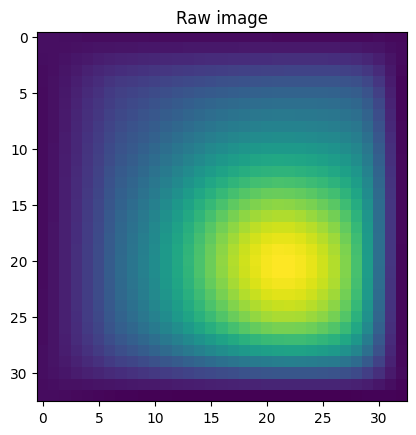

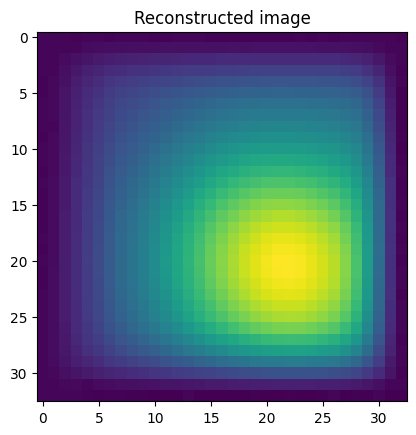

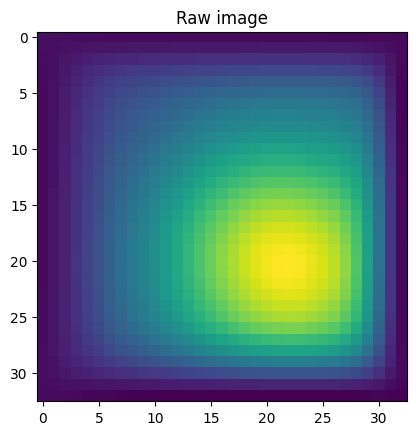

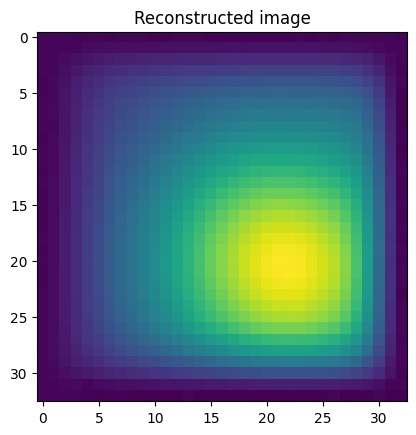

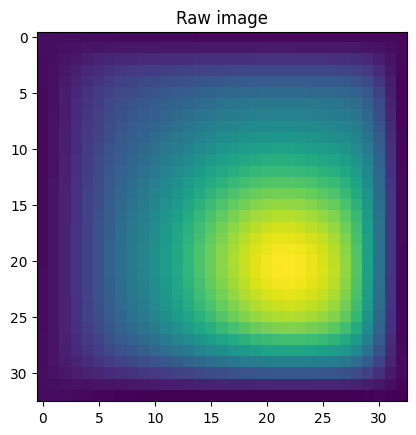

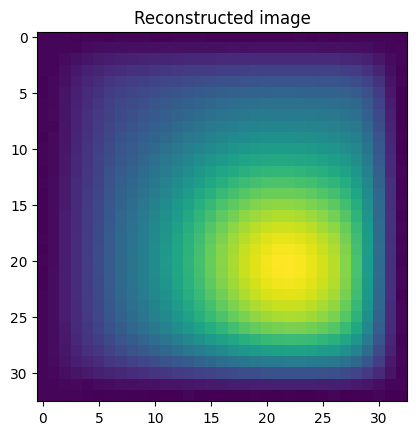

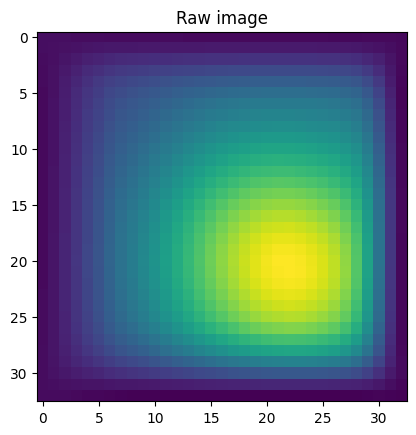

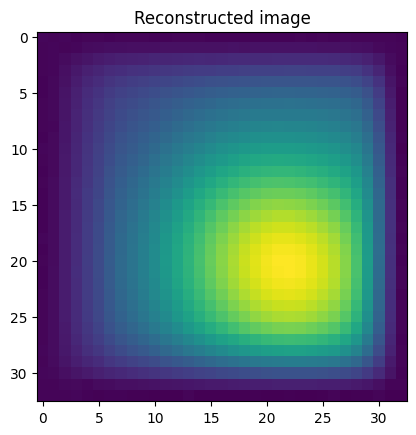

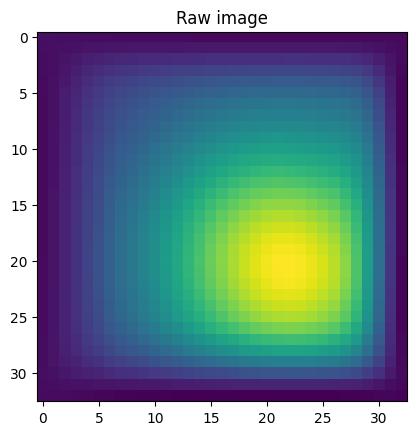

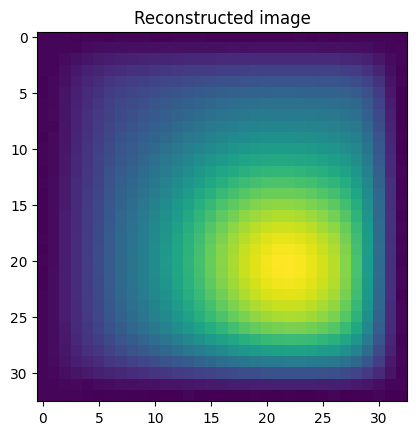

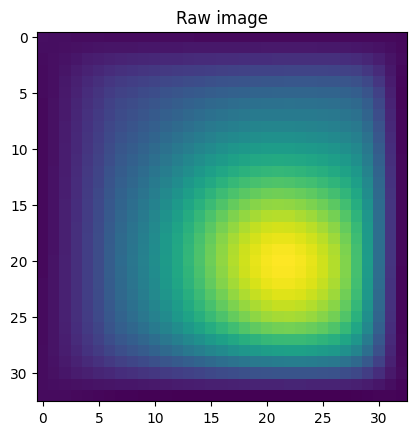

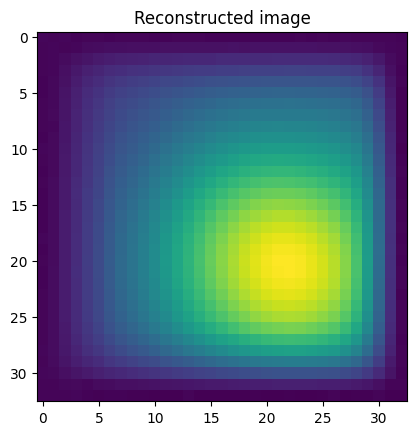

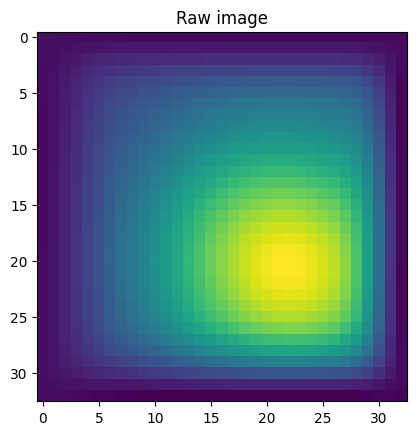

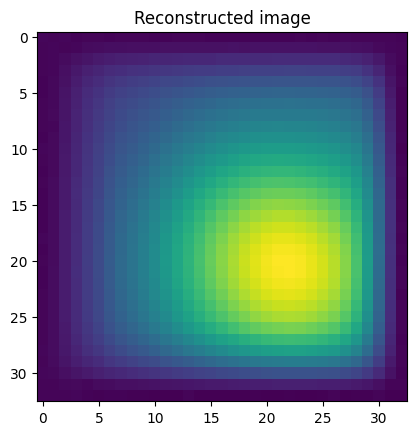

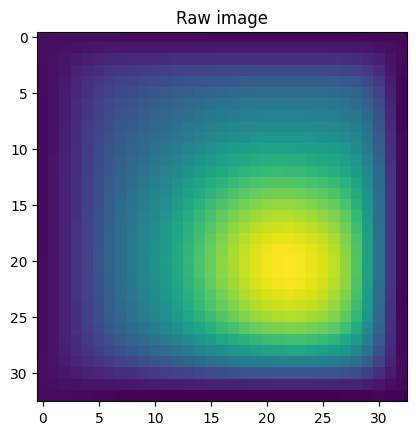

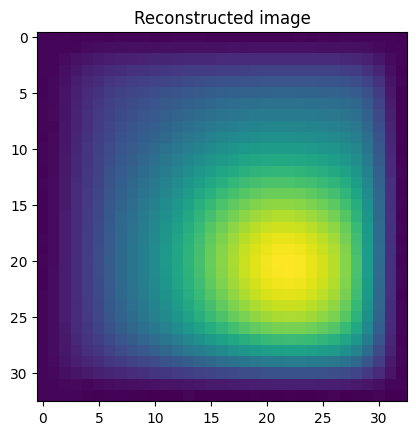

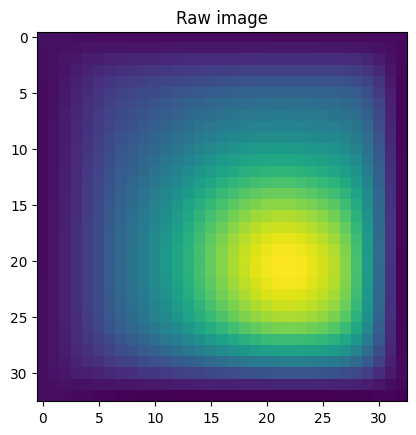

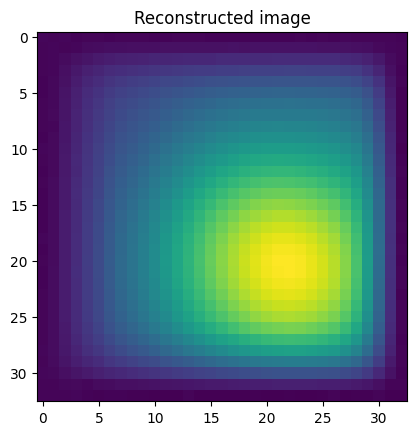

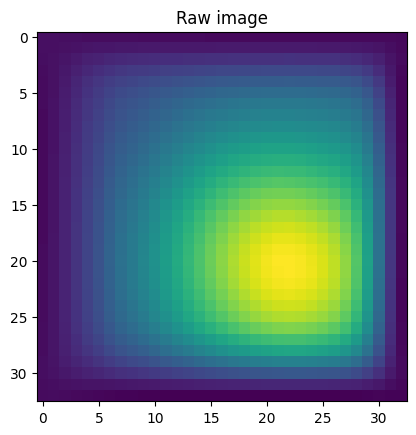

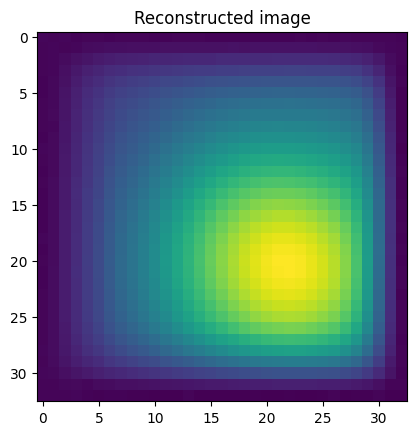

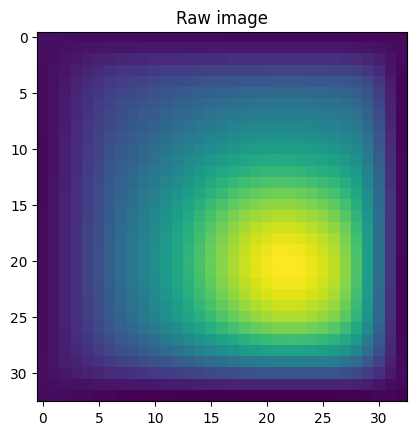

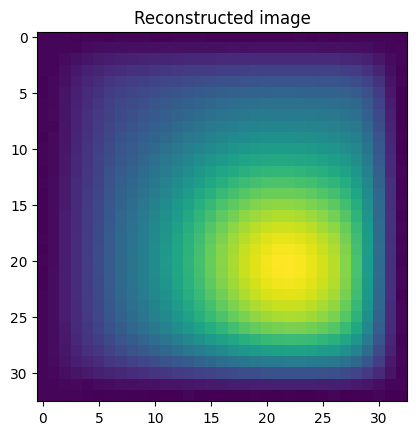

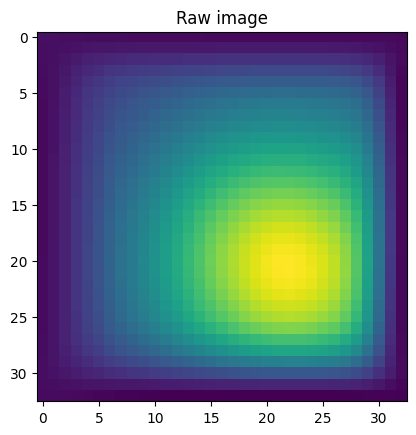

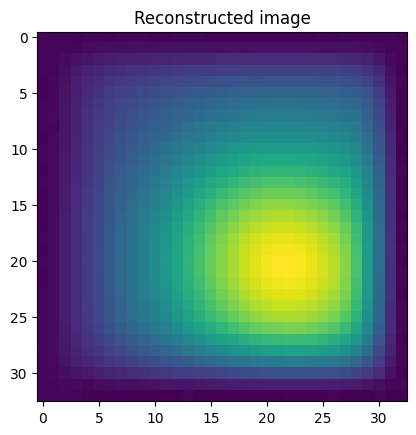

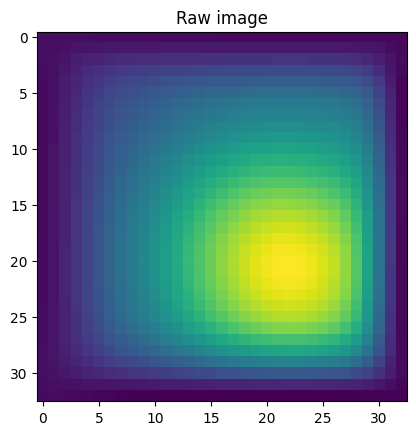

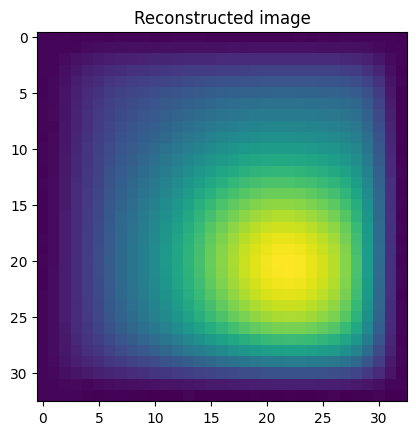

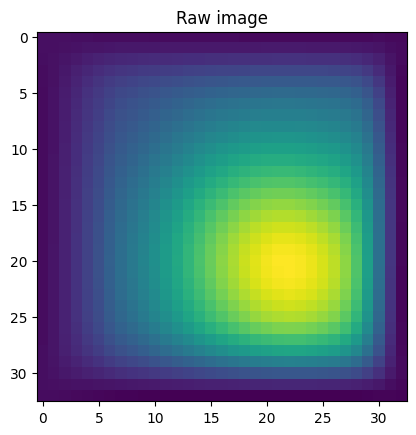

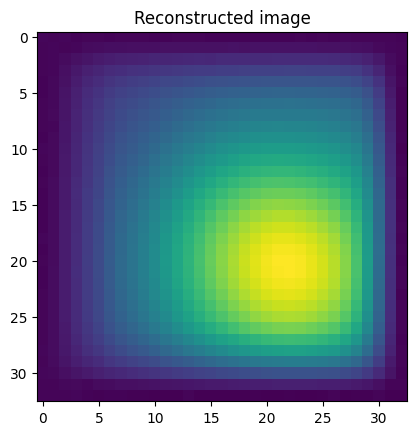

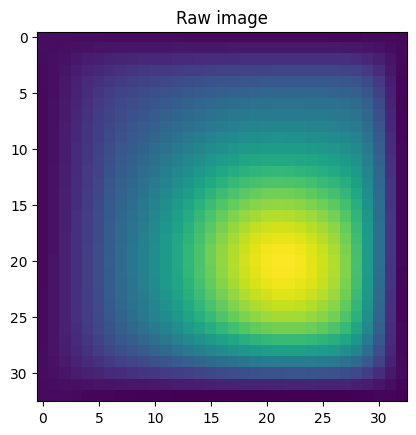

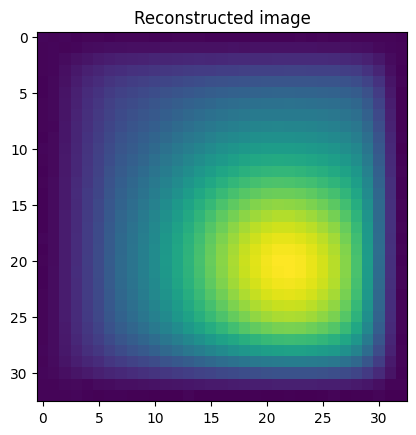

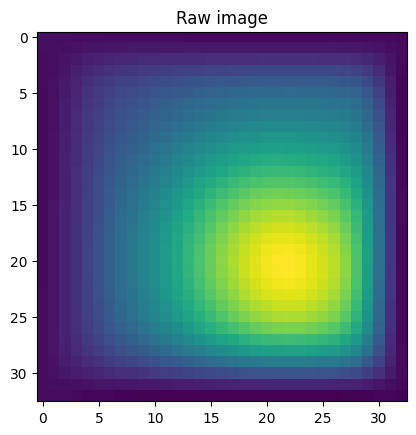

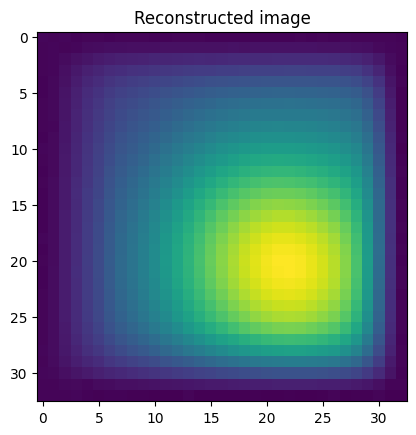

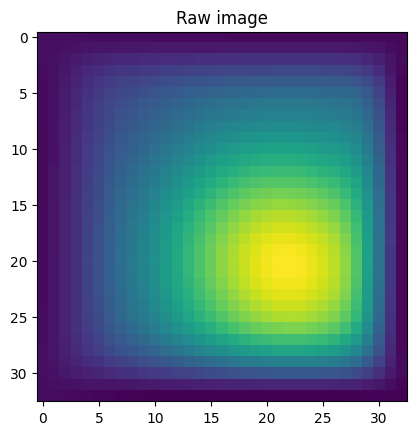

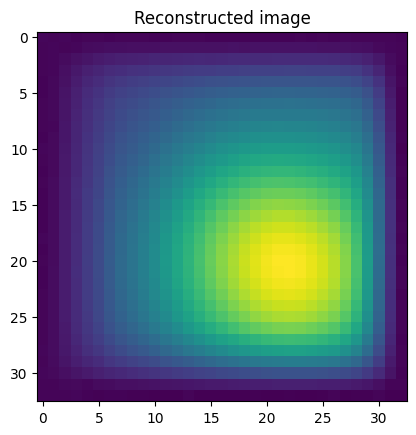

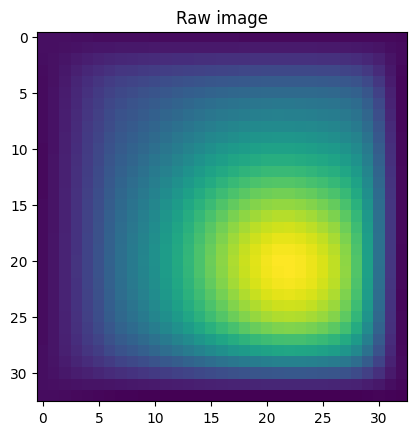

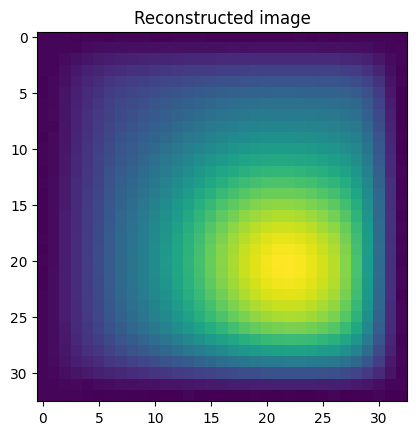

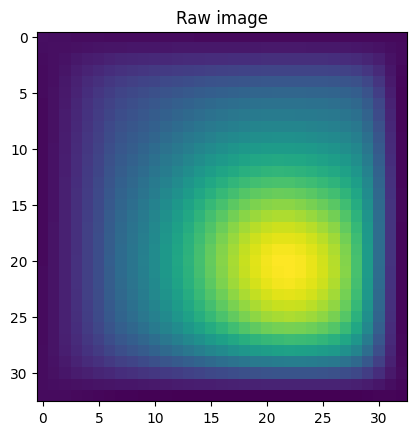

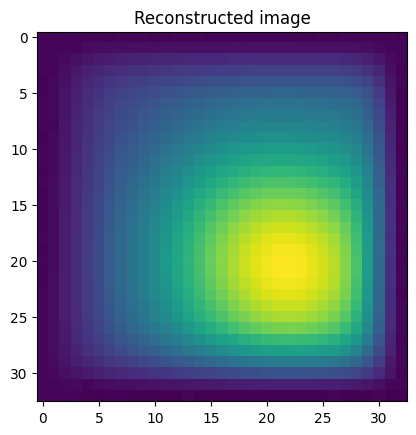

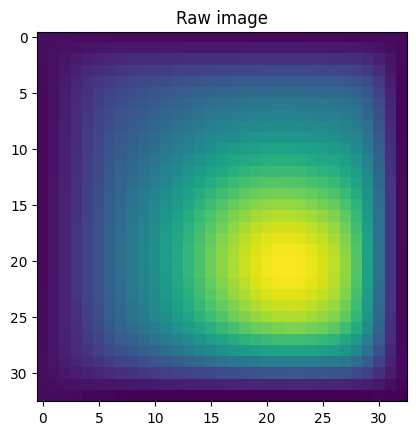

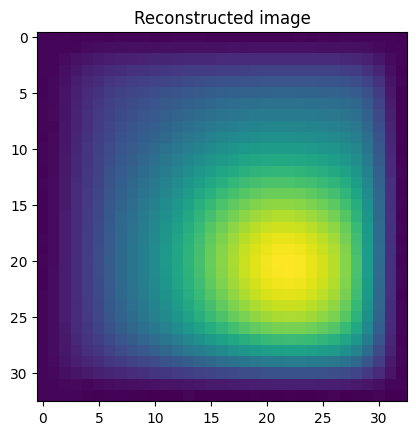

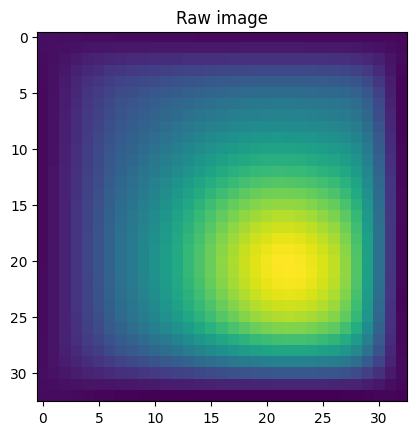

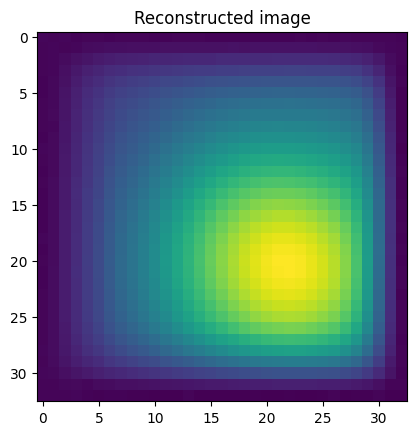

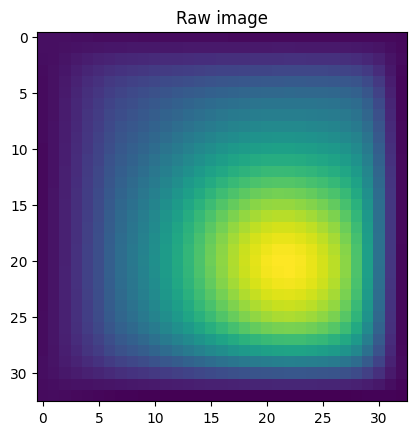

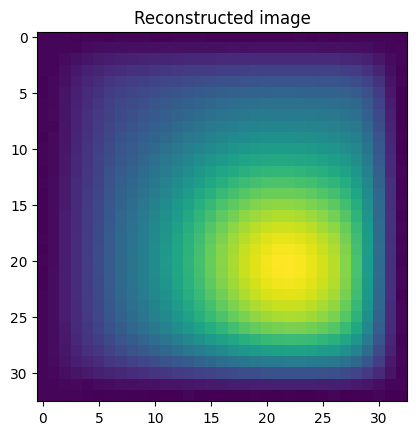

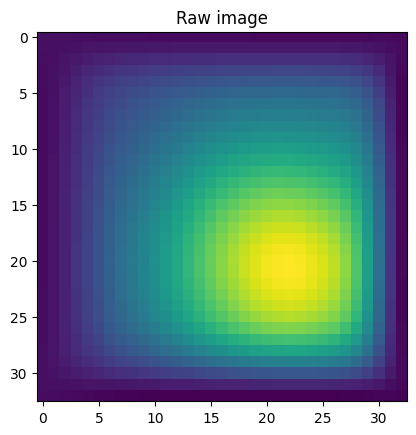

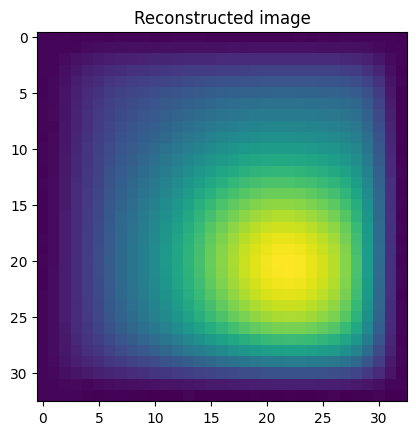

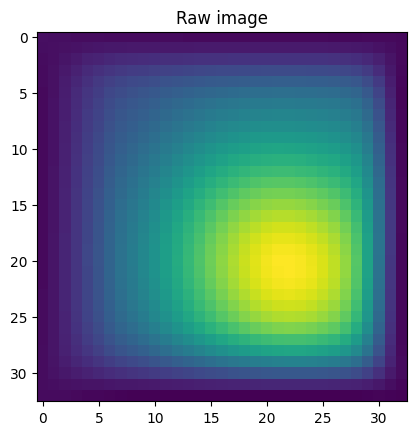

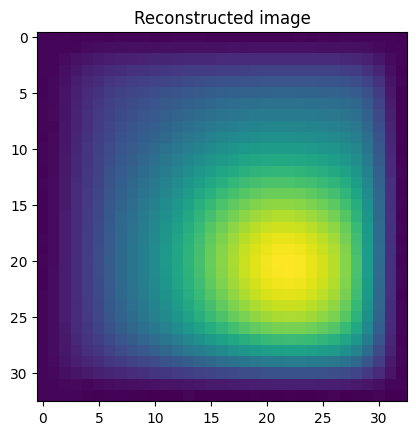

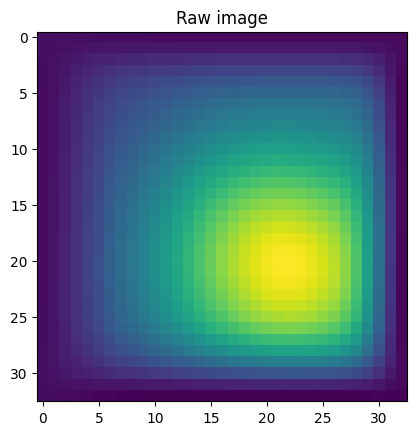

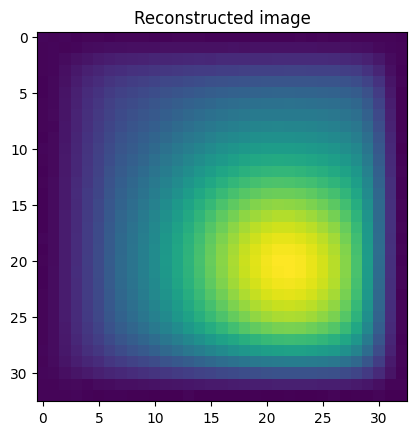

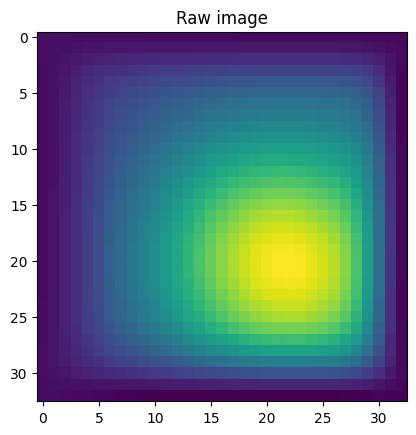

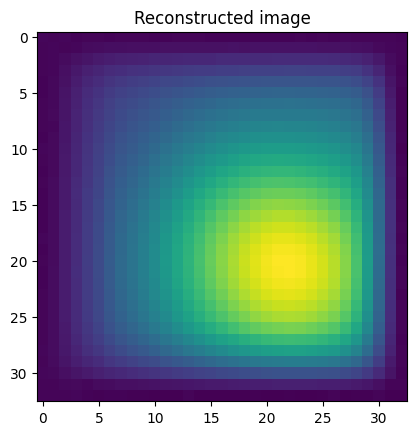

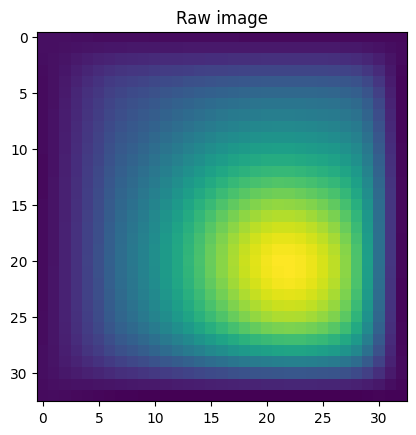

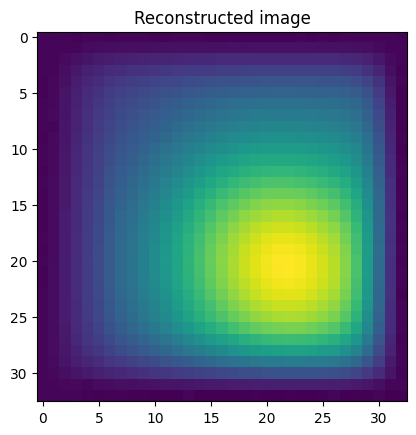

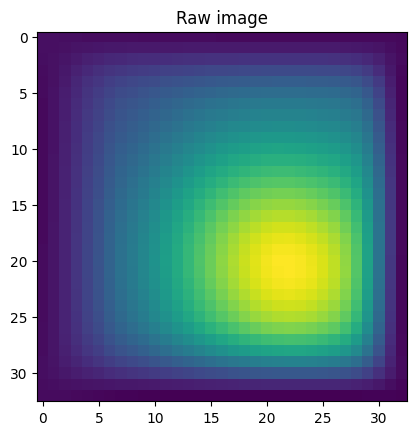

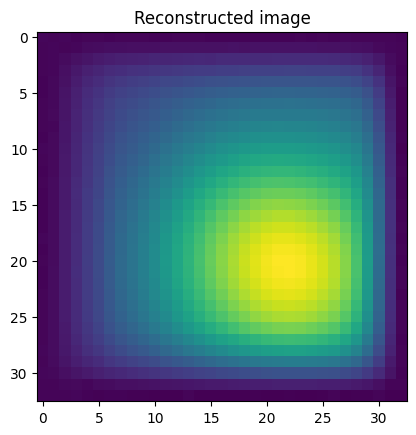

In [15]:
test_loss = reconstruct(test_loader,model,criterion,
                        dimension = decode_dimension,
                        encoder = ENCODER,
                        N        = N,
                        show     = True,
                        figs     = '.',
                        n_images = -1,
                        prefix   = 'foo')

In [16]:
def plot_losses(Losses,
                lr                   = 0.001,
                encoder              = [],
                decoder              = [],
                encoder_nonlinearity = None,
                decoder_nonlinearity = None,
                N                    = 25,
                show                 = False,
                figs                 = './figs',
                prefix               = 'ae',
                test_loss            = 0):
    '''Plot curve of training losses'''
    fig = figure(figsize=(10,10))
    ax  = fig.subplots()
    ax.plot(Losses)
    ax.set_ylim(bottom=0)
    ax.set_title(f'Training Losses after {N} epochs')
    ax.set_ylabel('RMSELoss')
    ax.text(0.95, 0.95, '\n'.join([f'lr = {lr}',
                                   f'encoder = {encoder}',
                                   f'decoder = {decoder}',
                                   f'encoder nonlinearity = {encoder_nonlinearity}',
                                   f'decoder nonlinearity = {decoder_nonlinearity}',
                                  #  f'test RMSE loss = {test_loss:.3f}'
                                   ]),
            transform           = ax.transAxes,
            fontsize            = 14,
            verticalalignment   = 'top',
            horizontalalignment = 'right',
            bbox                = dict(boxstyle  = 'round',
                                       facecolor = 'wheat',
                                       alpha     = 0.5))
    savefig(os.path.join(figs,f'{prefix}-losses'))
    if not show:
        close (fig)

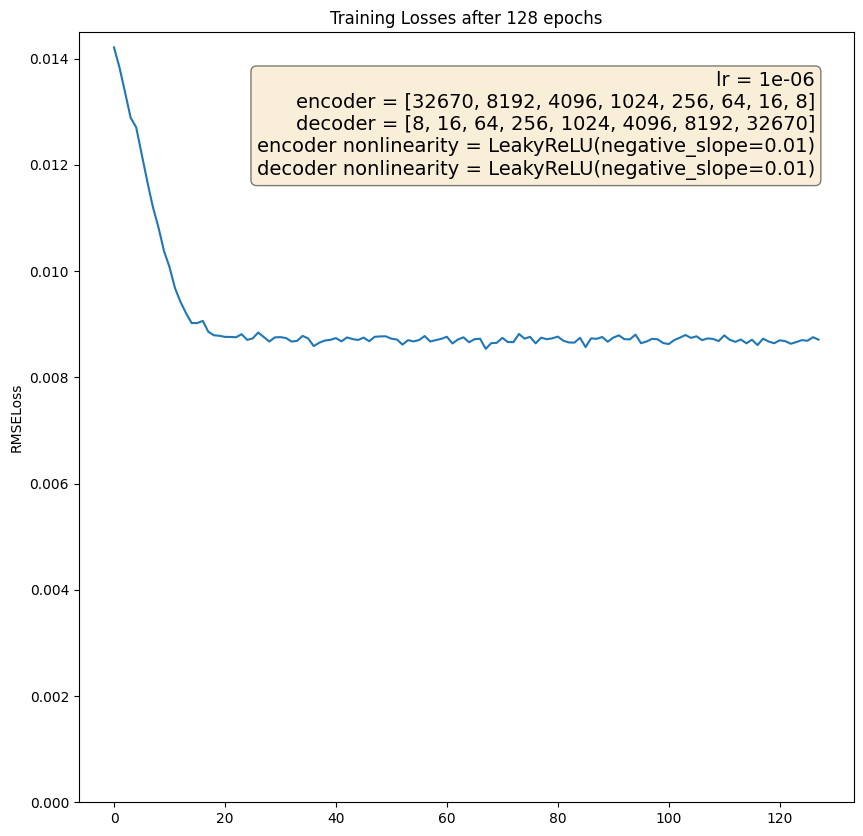

In [17]:
plot_losses(Losses,
                lr                   = LR,
                encoder              = model.encoder_sizes,
                decoder              = model.decoder_sizes,
                encoder_nonlinearity = encoder_non_linearity,
                decoder_nonlinearity = decoder_non_linearity,
                N                    = N,
                show                 = True,
                figs                 = '.',
                prefix               = 'foo',
                test_loss            = test_loss)

In [18]:
def plot_encoding(loader,model,encoder,
                figs    = './figs',
                dev     = 'cpu',
                colours = [],
                show    = False,
                prefix  = 'ae'):
    '''Plot the encoding layer

       Since this is multi,dimensional, we will break it into 2D plots
    '''
    def extract_batch(batch_features, labels,index):
        '''Extract xs, ys, and colours for one batch'''

        batch_features = batch_features.view(-1, encoder[0]).to(dev)
        encoded        = model(batch_features).tolist()

        return list(zip(*([encoded[k][2*index] for k in range(len(labels))],
                          [encoded[k][2*index+1] for k in range(len(labels))],
                          [colours[int(labels.tolist()[k])] for k in range(len(labels))])))

    save_decode  = model.decode
    model.decode = False
    with no_grad():
        fig     = figure(figsize=(10,10))
        ax      = fig.subplots(nrows=2,ncols=2)
        for i in range(2):
            for j in range(2):
                if i==1 and j==1: break
                index    = 2*i + j
                if 2*index+1 < model.n_encoded():
                    xs,ys,cs = tuple(zip(*[xyc for batch_features, labels in loader for xyc in extract_batch(batch_features, labels,index)]))
                    ax[i][j].set_title(f'{2*index}-{2*index+1}')
                    ax[i][j].scatter(xs,ys,c=cs,s=1)

    ax[0][0].legend(handles=[Line2D([], [],
                                    color  = colours[k],
                                    marker = 's',
                                    ls     = '',
                                    label  = f'{k}') for k in range(10)])
    savefig(os.path.join(figs,f'{prefix}-encoding'))
    if not show:
        close (fig)

    model.decode = save_decode

## Plot encode data

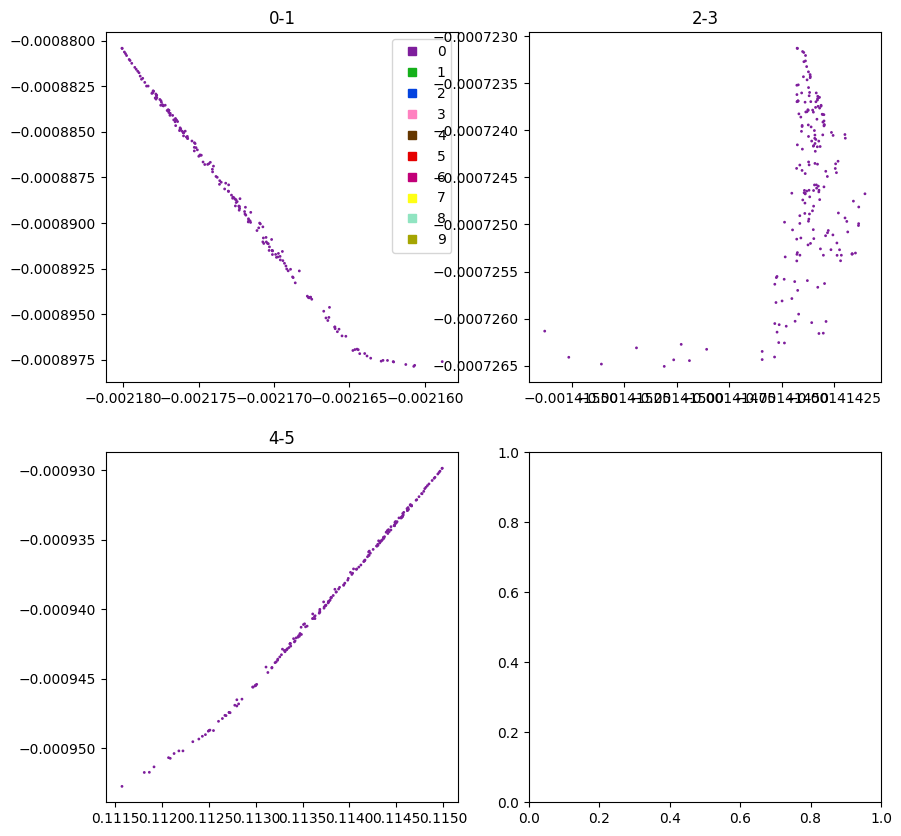

In [19]:
plot_encoding(test_loader,model,ENCODER,
              dev     = 'cuda',
                  show    = True,
                  colours = ['xkcd:purple',
                             'xkcd:green',
                             'xkcd:blue',
                             'xkcd:pink',
                             'xkcd:brown',
                             'xkcd:red',
                             'xkcd:magenta',
                             'xkcd:yellow',
                             'xkcd:light teal',
                             'xkcd:puke'],
                  figs    = '.',
                  prefix  = 'foo')

In [20]:
latent_vec = latent_vector_encoder(model, image.to(dev), ENCODER)

In [21]:
latent_vec.shape

torch.Size([196, 8])

In [60]:
latent_vec.cpu().detach().numpy()

array([[-0.00217672, -0.0008841 , -0.0014143 , ..., -0.00093405,
         0.23063923, -0.00122298],
       [-0.00216944, -0.00089156, -0.00141443, ..., -0.00094288,
         0.2330423 , -0.00121695],
       [-0.00217895, -0.00088176, -0.00141436, ..., -0.00093132,
         0.22989312, -0.00122476],
       ...,
       [-0.00217834, -0.00088249, -0.00141443, ..., -0.00093215,
         0.23009314, -0.0012243 ],
       [-0.00216757, -0.00089407, -0.00141438, ..., -0.00094561,
         0.23369388, -0.0012157 ],
       [-0.0021787 , -0.00088207, -0.00141438, ..., -0.00093167,
         0.22997735, -0.00122461]], dtype=float32)

In [63]:
np.save(file=os.path.join(folder_path, 'AE_models', 'aemodel_leakyReLU_128epoch_latent_vector.npy'), arr=latent_vec.cpu().detach().numpy())

In [54]:
# save_latent_vector(latent_vec.cpu().detach().numpy(), path2file='ae_latent_vector.csv')

In [56]:
reconstruct_image = ae_prediction(model, image.to(dev), ENCODER, dimension=decode_dimension)

In [61]:
print(f"The MSE of raw image compared to the re-constructed image by autoencoder is: {np.round(criterion(image.cpu(), reconstruct_image.cpu()).detach().numpy(),5)}")

The MSE of raw image compared to the re-constructed image by autoencoder is: 0.00013000000035390258


## Visualization of images

In [22]:
latent_vec = latent_vector_encoder(model, image.to(dev), ENCODER)
reconstruct_image = ae_prediction(model, image.to(dev), ENCODER, dimension=decode_dimension)
print(f"The MSE of raw image compared to the re-constructed image by autoencoder is: {np.round(criterion(image.cpu(), reconstruct_image.cpu()).detach().numpy(),5)}")

The MSE of raw image compared to the re-constructed image by autoencoder is: 7.999999797903001e-05


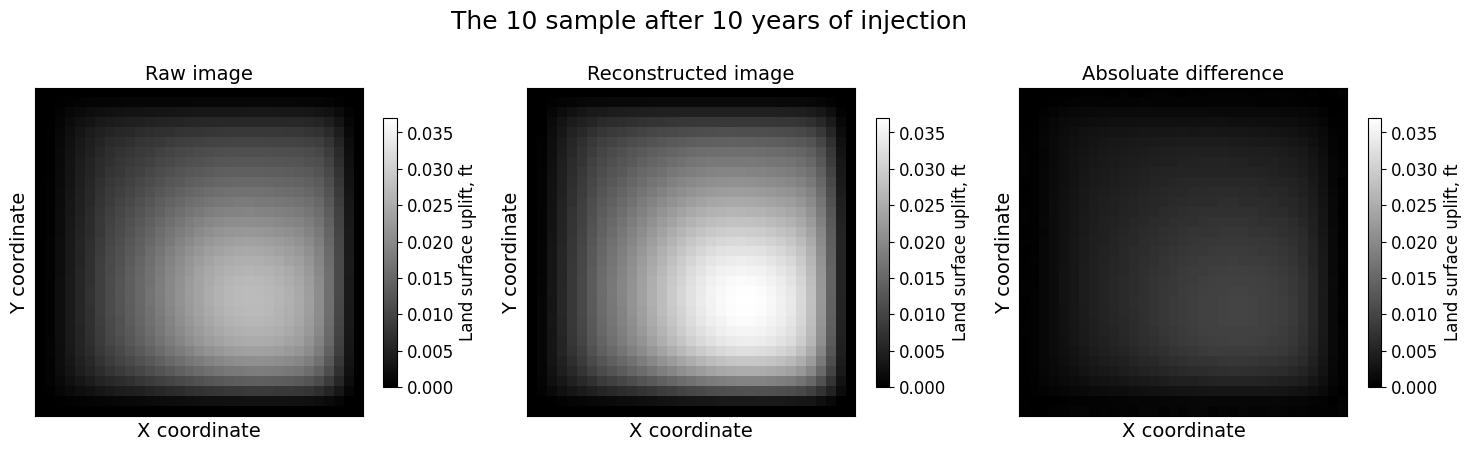

In [52]:
sample_idx = 10
time_idx = 10

plot_image_comparison(image=image.cpu().detach().numpy(),
                      ae_pred=reconstruct_image.cpu().detach().numpy(),
                      sample_idx=sample_idx,
                      time_idx=time_idx,
                      cbar_label = 'Land surface uplift, ft')

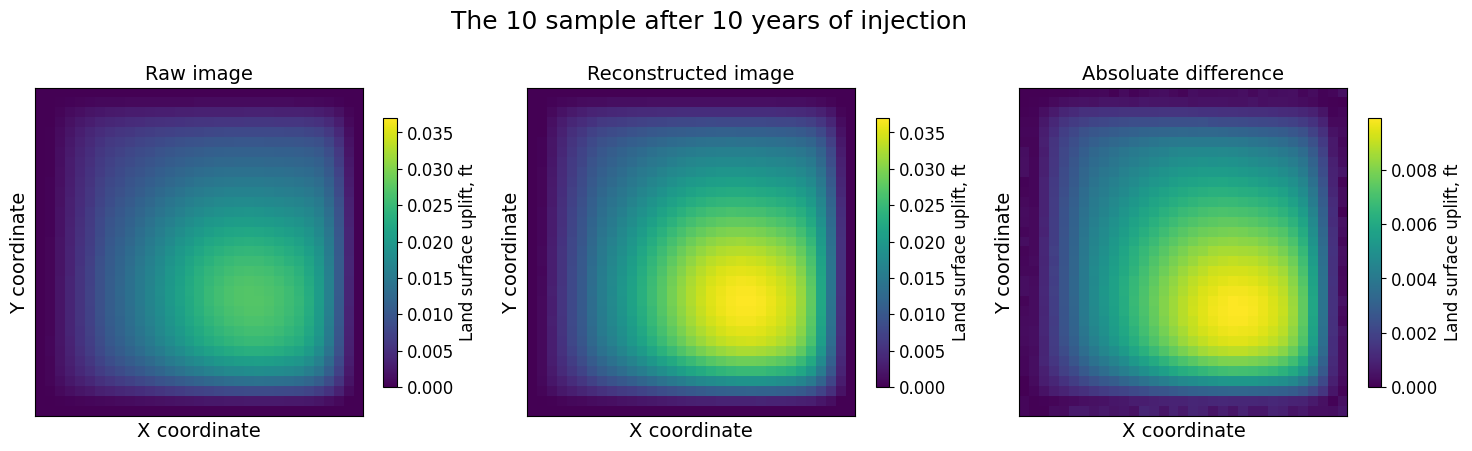

In [53]:
plot_image_comparison(image=image.cpu().detach().numpy(),
                      ae_pred=reconstruct_image.cpu().detach().numpy(),
                      sample_idx=sample_idx,
                      time_idx=time_idx,
                      cmap=False)